### Time series analysis using LSTM

With the help of an LSTM network, we will try to predict the future prices of Bitcoin. In order to do this, we used data a based on its price of the past 9 years and calculated technical analysis indicators. The historical data can be accessed by installing yfinance library (https://pypi.org/project/yfinance/).

In time series problems, we have to predict (forecast) a value at day (time) T, based on the data from N days before, starting at day T-N.  We will try predicting the adjusted close stock price of BTC based on the past N=60 days. One could try different values of N and see how precision of the forecasting algorithm changes with the length of the interval. 

We start feature exploration with a simple univariate model, then gradually add more predictors into the model. We use RMSE test score and validation error to compare different models and their performance.  

In [1]:
import numpy as np  
import pandas as pd  
from sklearn.preprocessing import MinMaxScaler  

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Dense  
from tensorflow.keras.layers import LSTM  
from tensorflow.keras.layers import Dropout  
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [2]:
# import pandas_datareader.data as web
import datetime as dt
import yfinance as yf
from varname import nameof

In [3]:
def webdata(stock):
        start = dt.date(2011,6,1)
        end = dt.date(2020,12,5)
        df = yf.download(stock,start=start, end=end, progress=False)
        df.reset_index(inplace=True)
        return  df

In [4]:
def plot_loss_hist(hist):
    loss = hist.history['loss']
    vloss = hist.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, vloss, 'b', label='Validation loss')
    plt.title('Loss plot')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [5]:
df_com = webdata('BTC-USD')
df_com.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2263,2020-12-01,19633.769531,19845.974609,18321.921875,18802.998047,18802.998047,49633658712
2264,2020-12-02,18801.744141,19308.330078,18347.718750,19201.091797,19201.091797,37387697139
2265,2020-12-03,19205.925781,19566.191406,18925.785156,19445.398438,19445.398438,31930317405
2266,2020-12-04,19446.966797,19511.404297,18697.193359,18699.765625,18699.765625,33872388058
2267,2020-12-05,18698.384766,19160.449219,18590.193359,19154.230469,19154.230469,27242455064


In [6]:
df_com['Date'] = pd.to_datetime(df_com['Date'])
df_com.shape

(2268, 7)

Before feeding the neural network, we need to normilize the data. We will use SciKit-Learn `MinMaxScaler` from `sklearn.preprocessing` libary. All values of the `Open` price will be scaled into the interval between 0 and 1.

In [7]:
scaler = MinMaxScaler(feature_range = (0, 1))

# Simple LSTM Model

In [8]:
df = df_com.iloc[:,[0,5]]
df.head()

,Date,Adj Close
0,2014-09-17,457.334015
1,2014-09-18,424.440002
2,2014-09-19,394.795990
3,2014-09-20,408.903992
4,2014-09-21,398.821014


In [9]:
df.shape

(2268, 2)

In [10]:
df_train = df[ (df['Date'] >= '2014-09-17') & (df['Date'] <= '2020-05-29')]
df_train

df_val = df_com[ (df['Date'] >= '2020-06-01') & (df['Date'] <= '2020-09-18')]
df_val
df_test = df_com[ (df['Date'] >= '2020-09-19') & (df['Date'] <= '2020-12-04')]
print (df_train.shape)
print (df_val.shape)
print (df_test.shape)

(2081, 2)
(110, 7)
(74, 7)


We will now create two lists: `feature_set` and `labels`. 

1- We execute a loop that starts from 61st record and stores all the previous 60 records to the `feature_set` list. The 61st record is stored in the `labels` list and so on. 

2- We then need to convert both the feature_set and the labels lists to the numpy arrays before we can use them for training.

3 - Last but not least, in order to train our LSTM model we need to convert our data into the three-dimensional shape accepted by the LSTM. The first dimension is the number of records or rows in the dataset which is 2021 in our case. The second dimension is the number of time steps which is 60. The last dimension is the number of indicators (labels). Since we are only using one value, i.e. column `Adj Close`, the number of indicators is 1 (one). 

In [11]:
time_steps = 60

def to_seq(df):
    df_sel = df.iloc[:, 1:2].values 
    df_scaled = scaler.fit_transform(df_sel)  # Normalize data

    features_set = []  
    labels = []  
    for i in range(time_steps, len(df_scaled)):  
        features_set.append(df_scaled[i-time_steps:i])
        labels.append(df_scaled[i, 0])
        
    features_set, labels = np.array(features_set), np.array(labels)  
    
    features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))   
    return features_set,labels

In [12]:
x_train, y_train = to_seq(df_train)
x_val, y_val = to_seq(df_val)
print(x_train.shape)
print(x_val.shape)

(2021, 60, 1)
(50, 60, 1)


In [13]:
df_train.head()

,Date,Adj Close
0,2014-09-17,457.334015
1,2014-09-18,424.440002
2,2014-09-19,394.795990
3,2014-09-20,408.903992
4,2014-09-21,398.821014


## Build and train the LSTM model
In order to train the model we will use tf.Keras API. The LSTM model we will create is sequential model with multiple layers. We will use four LSTM layers followed by a Dense layer that predicts the future price.

As a first step, we need to instantiate the Sequential class. This is our model class and we will add LSTM, Dropout and Dense layers to this model. 

The first parameter to the LSTM layer is the number of neurons or nodes that we want in the layer. The first parameter to the `input_shape` is the number of time steps while the last parameter is the number of indicators.

The second parameter is `return_sequences`, which is set to `True`. We are adding more LSTM layers to the model and every subsequent LSTM layer needs information about all outputs of all cells for every element of the input sequence. 

Parameter `return_sequences`=`True`: `Boolean` tells the cell whether to return the last output in the output sequence (`False`), or the full sequence (`True`). When `return_sequences=True` the cell returns the hidden state output for each input time step. When stacking LSTM layers, you must set `return_sequnce` to `True`

We are leaving 
`unroll=False`: `Boolean` (default `False`). If `True`, the network will be unrolled, else a symbolic loop will be used. Unrolling can speed-up an RNN or LSTM, although it tends to be more memory-intensive. Unrolling is only suitable for short sequences.

In order to avoid over-fitting, we will add Dropout layers.

The number of neurons, units = 96, in every LSTM subcell.

To make our model more robust, we add a dense layer at the end of the model. The number of neurons in the dense layer will be set to 1 since we want to predict a single value.

In [14]:
model = Sequential()  
model.add(LSTM(units=96, return_sequences=True, input_shape=(time_steps, 1),unroll=False)) 
model.add(Dropout(0.2))  
model.add(LSTM(units=96, return_sequences=True))  
model.add(Dropout(0.2))

model.add(LSTM(units=96, return_sequences=True))  
model.add(Dropout(0.2))

model.add(LSTM(units=96))  
model.add(Dropout(0.2))  
model.add(Dense(units = 1))  
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 96)            37632     
_________________________________________________________________
dropout (Dropout)            (None, 60, 96)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 96)            74112     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 96)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 96)            74112     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 96)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 96)                7

Finally, we need to compile our LSTM model before we can train it on the training data. We then train train the model by calling the `fit` method on the model.

In [15]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')  
history = model.fit(x_train, y_train, validation_data= (x_val, y_val),
                    epochs = 100, batch_size = 32)  

model.save('BTC_price_v1.h5') 

Epoch 1/100
64/64 [==============================] - 13s 121ms/step - loss: 0.0184 - val_loss: 0.0831
Epoch 2/100
64/64 [==============================] - 6s 92ms/step - loss: 0.0026 - val_loss: 0.0598
Epoch 3/100
64/64 [==============================] - 6s 93ms/step - loss: 0.0020 - val_loss: 0.0484
Epoch 4/100
64/64 [==============================] - 6s 92ms/step - loss: 0.0020 - val_loss: 0.0374
Epoch 5/100
64/64 [==============================] - 6s 91ms/step - loss: 0.0017 - val_loss: 0.0332
Epoch 6/100
64/64 [==============================] - 6s 92ms/step - loss: 0.0018 - val_loss: 0.0311
Epoch 7/100
64/64 [==============================] - 6s 101ms/step - loss: 0.0014 - val_loss: 0.0337
Epoch 8/100
64/64 [==============================] - 6s 98ms/step - loss: 0.0015 - val_loss: 0.0267
Epoch 9/100
64/64 [==============================] - 6s 97ms/step - loss: 0.0019 - val_loss: 0.0249
Epoch 10/100
64/64 [==============================] - 6s 98ms/step - loss: 0.0013 - val_loss: 0.0

64/64 [==============================] - 6s 98ms/step - loss: 6.3156e-04 - val_loss: 0.0091
Epoch 80/100
64/64 [==============================] - 7s 110ms/step - loss: 6.8891e-04 - val_loss: 0.0092
Epoch 81/100
64/64 [==============================] - 7s 106ms/step - loss: 6.6299e-04 - val_loss: 0.0085
Epoch 82/100
64/64 [==============================] - 7s 111ms/step - loss: 5.8017e-04 - val_loss: 0.0085
Epoch 83/100
64/64 [==============================] - 7s 106ms/step - loss: 5.4202e-04 - val_loss: 0.0085
Epoch 84/100
64/64 [==============================] - 7s 103ms/step - loss: 6.4950e-04 - val_loss: 0.0085
Epoch 85/100
64/64 [==============================] - 7s 105ms/step - loss: 5.1780e-04 - val_loss: 0.0084
Epoch 86/100
64/64 [==============================] - 7s 105ms/step - loss: 4.9243e-04 - val_loss: 0.0083
Epoch 87/100
64/64 [==============================] - 6s 101ms/step - loss: 7.3377e-04 - val_loss: 0.0083
Epoch 88/100
64/64 [==============================] - 7s 105

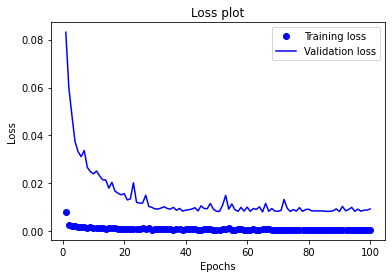

In [16]:
plot_loss_hist(history)

## Testing our LSTM
Having trained the model, we will pass on to testing the performance of by predicting the opening prices for the validation and test datasets. 

As we did with the training data, we need to convert our test data in the right format.

In [160]:
print(df_val.shape,df_test.shape)

(110, 7) (74, 7)


In [28]:
df_tst = pd.concat((df_val[['Date','Adj Close']], df_test[['Date','Adj Close']]), axis=0)  
df_tst.tail()

,Date,Adj Close
2262,2020-11-30,19625.835938
2263,2020-12-01,18802.998047
2264,2020-12-02,19201.091797
2265,2020-12-03,19445.398438
2266,2020-12-04,18699.765625


In [29]:
# df_tst = pd.concat((df_val.iloc[:, 0:2], df_test.iloc[:, 0:2]), axis=0)  
# df_tst.tail()

In [30]:
# df_tst1 = df_tst.iloc[:,0:2]
# df_tst1[:4]

In [34]:
df_tst2 = scaler.fit_transform(df_tst[['Adj Close']]) 

In [35]:
test_features = []  
for i in range( 60, len(df_tst2)+1 ):  
    test_features.append(df_tst2[i-60:i])

test_features = np.array(test_features)   
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1)) 
test_features.shape

(125, 60, 1)

Now we make predictions by calling the `predict()` method on the `model` that we trained.

In [36]:
pred = model.predict(test_features)  
print(pred.shape)
pred[5:10]

(125, 1)


array([[0.20715652],
       [0.22910786],
       [0.2461066 ],
       [0.24517462],
       [0.24842803]], dtype=float32)

Finally, we reverse the scaled predictions back to their actual values by using the `ìnverse_transform` method of the `scaler` object we created during the training.

In [37]:
pred = scaler.inverse_transform(pred) 
pred_df = pd.DataFrame(pred, columns =['Predict']) 
pred[5:10]

array([[11237.199],
       [11469.454],
       [11649.309],
       [11639.447],
       [11673.869]], dtype=float32)

In [38]:
df_tst1 = df_tst.iloc[60:len(df_tst), 0:2]
df_tst1 = df_tst1.rename(index = lambda x: x - df_tst1.index[0]) 

next_date = df_tst.iloc[len(df_tst)-1:len(df_tst), 0] + pd.to_timedelta(1,unit='d')
next_date.values[0]

df_tst1.loc[len(df_tst1.index)] = [ next_date.values[0], np.nan]  

df_tst2 = pd.concat((df_tst1, pred_df), axis=1)  
df_tst2.columns = ['Date', 'Actual', 'Predict']
df_tst2

,Date,Actual,Predict
0,2020-07-31,11323.466797,11017.541016
1,2020-08-01,11759.592773,11166.635742
2,2020-08-02,11053.614258,11463.000000
3,2020-08-03,11246.348633,11325.675781
4,2020-08-04,11205.892578,11265.573242
...,...,...,...
120,2020-12-01,18802.998047,18947.154297
121,2020-12-02,19201.091797,17887.240234
122,2020-12-03,19445.398438,18606.724609
123,2020-12-04,18699.765625,18712.884766


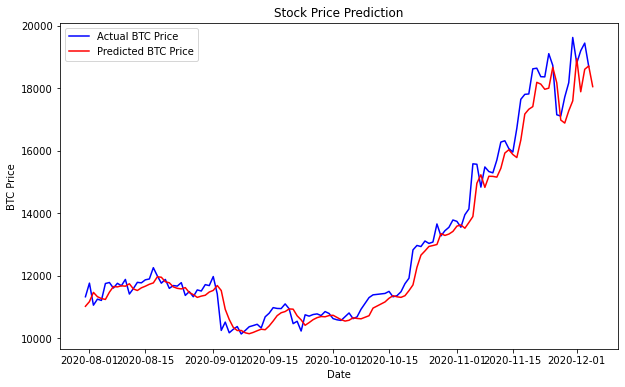

In [39]:
plt.figure(figsize=(10,6))  
plt.plot(df_tst2['Date'], df_tst2['Actual'], 'b', label='Actual BTC Price')  
plt.plot(df_tst2['Date'], df_tst2['Predict'], 'r', label='Predicted BTC Price')  
plt.title('Stock Price Prediction')  
plt.xlabel('Date')  
plt.ylabel('BTC Price')  
plt.legend()  
plt.show()  

In [40]:
df_tst4 = df_tst2.iloc[0:len(df_tst2)-1,] 
df_tst4

testScore = mean_squared_error(df_tst4['Actual'], df_tst4['Predict'], 
                               squared=False)
print("Test Score: %.2f RMSE" % (testScore))

Test Score: 494.31 RMSE


We will now perform the same analysis but add the RSI index (T-1) as input.

# LSTM : Px_Adj & RSI

In [41]:
df = df_com.iloc[:,[0,5]]
delta = df['Adj Close'].diff() 
up = delta.clip(lower=0)
down = -1*delta.clip(upper=0)
ema_up = up.ewm(com=13, adjust=False).mean()
ema_down = down.ewm(com=13, adjust=False).mean()
rs = ema_up/ema_down
df['RSI'] =  100 - (100/(1 + rs))
# Skip first 14 days to have real values
df = df.iloc[15:]

<ipython-input-41-0f6d6cdd7481>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RSI'] =  100 - (100/(1 + rs))


In [42]:
data = df.copy()
data['ema_fast'] = df['Adj Close'].ewm(span=12).mean()
data['ema_slow'] = df['Adj Close'].ewm(span=26).mean()
data['macd'] = data.ema_fast - data.ema_slow
data['signal'] = data.macd.ewm(span=9).mean()
data['histograma'] = data.macd - data.signal

# df['macd']= data['macd'] 
df['histo_macd']= data['histograma'] 

In [43]:
df_train = df[(df['Date'] >= '2014-09-17') & (df['Date'] <= '2020-05-29')]
df_train

df_val = df[(df['Date'] >= '2020-06-01') & (df['Date'] <= '2020-09-18')]
df_val
df_test = df[(df['Date'] >= '2020-09-19') & (df['Date'] <= '2020-12-04')]
print (df_train.shape)
print (df_val.shape)
print (df_test.shape)

(2066, 4)
(110, 4)
(74, 4)


In [44]:
df.head()

,Date,Adj Close,RSI,histo_macd
15,2014-10-02,375.071991,13.038347,0.000000
16,2014-10-03,359.511993,12.262814,-0.155157
17,2014-10-04,328.865997,10.889037,-0.708911
18,2014-10-05,320.510010,10.542246,-0.960246
19,2014-10-06,330.079010,13.923041,-0.659200


In [45]:
scaler = MinMaxScaler(feature_range = (0, 1))

In [46]:
time_steps = 60

def to_seq(df):
    df_sel = df.iloc[:, 1:5].values 
    df_scaled = scaler.fit_transform(df_sel)  

    features_set = []  
    labels = []  
    for i in range(time_steps, len(df_scaled)):  
        features_set.append(df_scaled[i-time_steps:i])
        labels.append(df_scaled[i, 0])

    features_set, labels = np.array(features_set), np.array(labels)  

    features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 3))  
    return features_set,labels

In [47]:
x_train, y_train = to_seq(df_train)
x_val, y_val = to_seq(df_val)
print(x_train.shape)
print(x_val.shape)

(2006, 60, 3)
(50, 60, 3)


In [48]:
model = Sequential()  
model.add(LSTM(units=96, return_sequences=True, input_shape=(time_steps, 3),unroll=False)) 
model.add(Dropout(0.2))  
model.add(LSTM(units=96, return_sequences=True))  
model.add(Dropout(0.2))

model.add(LSTM(units=96, return_sequences=True))  
model.add(Dropout(0.2))

model.add(LSTM(units=96))  
model.add(Dropout(0.2))  
model.add(Dense(units = 1))  
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 60, 96)            38400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 96)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 60, 96)            74112     
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 96)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 60, 96)            74112     
_________________________________________________________________
dropout_6 (Dropout)          (None, 60, 96)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 96)               

In [49]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')  
history = model.fit(x_train, y_train, validation_data= (x_val, y_val),
                    epochs = 100, batch_size = 32)  

model.save('btc_model_rsi.h5') 

Epoch 1/100
63/63 [==============================] - 13s 125ms/step - loss: 0.0181 - val_loss: 0.0839
Epoch 2/100
63/63 [==============================] - 7s 104ms/step - loss: 0.0029 - val_loss: 0.0700
Epoch 3/100
63/63 [==============================] - 6s 102ms/step - loss: 0.0033 - val_loss: 0.0527
Epoch 4/100
63/63 [==============================] - 6s 103ms/step - loss: 0.0019 - val_loss: 0.0519
Epoch 5/100
63/63 [==============================] - 6s 99ms/step - loss: 0.0019 - val_loss: 0.0394
Epoch 6/100
63/63 [==============================] - 6s 101ms/step - loss: 0.0021 - val_loss: 0.0399
Epoch 7/100
63/63 [==============================] - 6s 101ms/step - loss: 0.0018 - val_loss: 0.0313
Epoch 8/100
63/63 [==============================] - 7s 104ms/step - loss: 0.0021 - val_loss: 0.0316
Epoch 9/100
63/63 [==============================] - 7s 114ms/step - loss: 0.0016 - val_loss: 0.0289
Epoch 10/100
63/63 [==============================] - 7s 105ms/step - loss: 0.0014 - val_lo

Epoch 80/100
63/63 [==============================] - 6s 96ms/step - loss: 5.6316e-04 - val_loss: 0.0094
Epoch 81/100
63/63 [==============================] - 6s 94ms/step - loss: 6.0417e-04 - val_loss: 0.0094
Epoch 82/100
63/63 [==============================] - 6s 94ms/step - loss: 5.8707e-04 - val_loss: 0.0089
Epoch 83/100
63/63 [==============================] - 6s 98ms/step - loss: 5.6339e-04 - val_loss: 0.0104
Epoch 84/100
63/63 [==============================] - 6s 102ms/step - loss: 7.7041e-04 - val_loss: 0.0103
Epoch 85/100
63/63 [==============================] - 6s 94ms/step - loss: 7.2463e-04 - val_loss: 0.0088
Epoch 86/100
63/63 [==============================] - 6s 94ms/step - loss: 6.9995e-04 - val_loss: 0.0110
Epoch 87/100
63/63 [==============================] - 6s 94ms/step - loss: 6.0819e-04 - val_loss: 0.0096
Epoch 88/100
63/63 [==============================] - 6s 94ms/step - loss: 7.0983e-04 - val_loss: 0.0091
Epoch 89/100
63/63 [==============================] - 

From the above, we see that our model history contains information on the training and the validation loss.

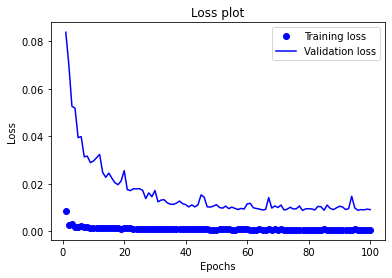

In [50]:
plot_loss_hist(history)

In [51]:
df_tst = pd.concat((df_val, df_test), axis=0)  
df_tst[:4]

df_tst1 = df_tst.iloc[:, 1:4]
df_tst1[:4]

,Adj Close,RSI,histo_macd
2083,10167.268555,64.339654,21.374026
2084,9529.803711,54.236190,6.771524
2085,9656.717773,55.726822,3.245412
2086,9800.636719,57.420541,7.924427


In [61]:
df_tst.head()

,Date,Adj Close,RSI,histo_macd
2083,2020-06-01,10167.268555,64.339654,21.374026
2084,2020-06-02,9529.803711,54.236190,6.771524
2085,2020-06-03,9656.717773,55.726822,3.245412
2086,2020-06-04,9800.636719,57.420541,7.924427
2087,2020-06-05,9665.533203,55.282473,-0.323649


In [52]:
df_tst2 = scaler.fit_transform(df_tst1) 
df_tst2[:4]

array([[0.10603315, 0.56956984, 0.52388043],
       [0.04578381, 0.38270974, 0.48995912],
       [0.05777896, 0.41027847, 0.48176804],
       [0.07138131, 0.44160322, 0.49263729]])

In [53]:
test_features = []  
for i in range( 60, len(df_tst2)+1 ):  
    test_features.append(df_tst2[i-60:i])

test_features = np.array(test_features)  
test_features = np.reshape(test_features, (test_features.shape[0], 
                                           test_features.shape[1], 3)) 
test_features.shape

(125, 60, 3)

In [54]:
pred = model.predict(test_features)  
print(pred.shape)

scaler.fit(df_tst1.iloc[:, [0]]) 

pred1 = scaler.inverse_transform(pred) 

pred1_df = pd.DataFrame(pred1, columns =['Predict']) 
pred1[5:10]

(125, 1)


array([[11325.671],
       [11574.834],
       [11756.764],
       [11685.708],
       [11702.078]], dtype=float32)

In [55]:
df_tst1 = df_tst.iloc[60:len(df_tst), 0:2]
df_tst1 = df_tst1.rename(index = lambda x: x - df_tst1.index[0]) 
df_tst1
next_date = df_tst.iloc[len(df_tst)-1:len(df_tst), 0] + pd.to_timedelta(1,unit='d')
next_date.values[0]

df_tst1.loc[len(df_tst1.index)] = [ next_date.values[0], np.nan]  
df_tst1

,Date,Adj Close
0,2020-07-31,11323.466797
1,2020-08-01,11759.592773
2,2020-08-02,11053.614258
3,2020-08-03,11246.348633
4,2020-08-04,11205.892578
...,...,...
120,2020-12-01,18802.998047
121,2020-12-02,19201.091797
122,2020-12-03,19445.398438
123,2020-12-04,18699.765625


In [56]:
df_tst2 = pd.concat((df_tst1, pred1_df), axis=1)  
df_tst2.columns = ['Date', 'Actual', 'Predict']
df_tst2

,Date,Actual,Predict
0,2020-07-31,11323.466797,11181.060547
1,2020-08-01,11759.592773,11390.496094
2,2020-08-02,11053.614258,11743.149414
3,2020-08-03,11246.348633,11403.654297
4,2020-08-04,11205.892578,11324.873047
...,...,...,...
120,2020-12-01,18802.998047,19464.035156
121,2020-12-02,19201.091797,17577.648438
122,2020-12-03,19445.398438,18604.001953
123,2020-12-04,18699.765625,18854.250000


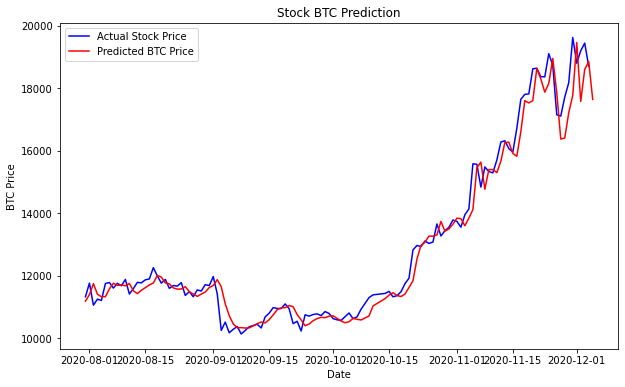

In [57]:
plt.figure(figsize=(10,6))  
plt.plot(df_tst2['Date'], df_tst2['Actual'], 'b', 
         label='Actual Stock Price')  
plt.plot(df_tst2['Date'], df_tst2['Predict'], 'r', 
         label='Predicted BTC Price')  
plt.title('Stock BTC Prediction')  
plt.xlabel('Date')  
plt.ylabel('BTC Price')  
plt.legend()  
plt.show()  

In [58]:
df_tst4 = df_tst2.iloc[0:len(df_tst2)-1,] 
df_tst4

testScore = mean_squared_error(df_tst4['Actual'], 
                               df_tst4['Predict'], squared=False)
print("Test Score: %.2f RMSE" % (testScore))

Test Score: 474.20 RMSE
